In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDASProj').getOrCreate()

In [2]:
#reading it in
df = spark.read.csv('/home/ubuntu/BDASProj/usa_00007.csv',header=True)
df.columns

['YEAR',
 'SAMPLE',
 'SERIAL',
 'CBSERIAL',
 'HHWT',
 'STATEICP',
 'GQ',
 'PERNUM',
 'PERWT',
 'SEX',
 'AGE',
 'MARST',
 'RACE',
 'RACED',
 'EDUC',
 'EDUCD',
 'EMPSTAT',
 'EMPSTATD',
 'OCC',
 'INCWAGE']

In [3]:
#deleting unwanted columns, and setting up df schema
from pyspark.sql.types import DoubleType

#deleting columns and showing new df
df2 = df.select([c for c in df.columns if c not in {'YEAR','SAMPLE',"SERIAL","CBSERIAL","HHWT","STATEICP","GQ","PERNUM","PERWT","RACED","EDUCD","EMPSTAT","EMPSTATD"}])
df2.show()
df2.columns

+---+---+-----+----+----+----+-------+
|SEX|AGE|MARST|RACE|EDUC| OCC|INCWAGE|
+---+---+-----+----+----+----+-------+
|  2| 31|    6|   1|  10| 350|  38500|
|  2| 37|    4|   2|   6| 230|  18000|
|  1| 21|    6|   2|   7|4620|  15000|
|  1| 20|    6|   2|   7|4120|   1200|
|  1| 61|    2|   1|  10|1410| 160000|
|  1| 62|    1|   2|  10| 430| 100000|
|  2| 58|    1|   2|  10|4710| 344000|
|  1| 30|    6|   2|  10|4710| 120000|
|  1| 26|    6|   2|  10|4850|  50000|
|  2| 55|    6|   1|   7|4500|      0|
|  1| 54|    4|   1|  10|4840|  56000|
|  1| 36|    4|   1|   6|9130|  24700|
|  1| 50|    1|   1|  11|2200| 344000|
|  2| 47|    1|   1|   6|2340|  10000|
|  2| 47|    1|   2|   8|4510|  15000|
|  1| 53|    1|   2|   8|4760|  30000|
|  2| 26|    6|   1|   7|5220|  25000|
|  1| 22|    6|   2|   7|8965|  29500|
|  1| 48|    1|   1|   6|3740|  65000|
|  2| 49|    1|   1|  10|3600|  65000|
+---+---+-----+----+----+----+-------+
only showing top 20 rows



['SEX', 'AGE', 'MARST', 'RACE', 'EDUC', 'OCC', 'INCWAGE']

In [4]:
#change values within columns (all except OCC)
sexDict = {'1':'Male','2':'Female'} 
df2 = df2.na.replace(sexDict,1,"SEX")

mDict = {'1':'Married','2':'Married','3':'Separated','4':'Separated','5':'Widowed','6':'NeverMarried-Single'}
df2 = df2.na.replace(mDict,1,"MARST")

rDict = {'1': "White", '2': "Black", '3': "Native-IndianOrAlaskan", '4': "Chinese", '5': "Japanese", '6': "OtherAsianOrPacificIslander"}
df2 = df2.na.replace(rDict,1,"RACE")

eDict = {'0': "NoSchooling", '1': "NurseryToKinderGarten", '2': "MiddleSchool", '3': "HighSchool", '4': "HighSchool", '5': "HighSchool", '6': "HighSchool",'7': "1stYearCollege", '8': "2ndYearCollege", '9': "3rdYearCollege", '10': "4thYearCollege", '11': "5+YearsCollege"}
df2 = df2.na.replace(eDict,1,"EDUC")
df2.show()

#removing 7,8,9 from RACE (we dont consider those race codes)
df2 = df2.filter('RACE not in ("7","8","9")')
df2.select('RACE').distinct().show()

+------+---+-------------------+-----+--------------+----+-------+
|   SEX|AGE|              MARST| RACE|          EDUC| OCC|INCWAGE|
+------+---+-------------------+-----+--------------+----+-------+
|Female| 31|NeverMarried-Single|White|4thYearCollege| 350|  38500|
|Female| 37|          Separated|Black|    HighSchool| 230|  18000|
|  Male| 21|NeverMarried-Single|Black|1stYearCollege|4620|  15000|
|  Male| 20|NeverMarried-Single|Black|1stYearCollege|4120|   1200|
|  Male| 61|            Married|White|4thYearCollege|1410| 160000|
|  Male| 62|            Married|Black|4thYearCollege| 430| 100000|
|Female| 58|            Married|Black|4thYearCollege|4710| 344000|
|  Male| 30|NeverMarried-Single|Black|4thYearCollege|4710| 120000|
|  Male| 26|NeverMarried-Single|Black|4thYearCollege|4850|  50000|
|Female| 55|NeverMarried-Single|White|1stYearCollege|4500|      0|
|  Male| 54|          Separated|White|4thYearCollege|4840|  56000|
|  Male| 36|          Separated|White|    HighSchool|9130|  24

In [5]:
#retaining only non-zero INCWAGEs
df2_buck = df2.filter(df2['INCWAGE']>0)

In [6]:
#Monumental Task: Reclassifying OCC
from pyspark.ml.feature import Bucketizer

#first convert stringtype of occrecode to doubletype
df2 = df2.withColumn("OCC", df2["OCC"].cast(DoubleType()))

#then reclassify
bucketizer = Bucketizer(splits=[0,741,951,1966,2060,2161,2551,2921,3656,3956,4651,4966,5941,6131,9751,9921],
                       inputCol="OCC",outputCol="OCCRecode")
df2_buck = bucketizer.setHandleInvalid("keep").transform(df2)

#showing the occrecode column, as well as the number of distinct values (Showing it Worked!)
df2_buck.show()

+------+---+-------------------+-----+--------------+------+-------+---------+
|   SEX|AGE|              MARST| RACE|          EDUC|   OCC|INCWAGE|OCCRecode|
+------+---+-------------------+-----+--------------+------+-------+---------+
|Female| 31|NeverMarried-Single|White|4thYearCollege| 350.0|  38500|      0.0|
|Female| 37|          Separated|Black|    HighSchool| 230.0|  18000|      0.0|
|  Male| 21|NeverMarried-Single|Black|1stYearCollege|4620.0|  15000|      9.0|
|  Male| 20|NeverMarried-Single|Black|1stYearCollege|4120.0|   1200|      9.0|
|  Male| 61|            Married|White|4thYearCollege|1410.0| 160000|      2.0|
|  Male| 62|            Married|Black|4thYearCollege| 430.0| 100000|      0.0|
|Female| 58|            Married|Black|4thYearCollege|4710.0| 344000|     10.0|
|  Male| 30|NeverMarried-Single|Black|4thYearCollege|4710.0| 120000|     10.0|
|  Male| 26|NeverMarried-Single|Black|4thYearCollege|4850.0|  50000|     10.0|
|Female| 55|NeverMarried-Single|White|1stYearCollege

In [7]:
#continuing...
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

t = {0.0:'Business',1.0:'Finance',2.0:'STEM',3.0:'PublicSector',4.0:'Law',
     5.0:'Education',6.0:'Media',7.0:'Healthcare',8.0:'PublicSector',9.0:
     'Hospitality',10.0:'Sales',11.0:'Administration',12.0:'STEM',13.0:'Trades',14.0:'PublicSector'}
udf_foo = udf(lambda x: t[x], StringType())
df3 = df2_buck.withColumn('OCCRecode',udf_foo("OCCRecode"))

#showing the new recoded occupations
df3.select("OCCRecode").distinct().show()

+--------------+
|     OCCRecode|
+--------------+
|     Education|
|         Sales|
|    Healthcare|
|  PublicSector|
|       Finance|
|         Media|
|          STEM|
|   Hospitality|
|Administration|
|           Law|
|      Business|
|        Trades|
+--------------+



In [8]:
#showing levels of each categorical value
df3.select("MARST").distinct().show()

+-------------------+
|              MARST|
+-------------------+
|          Separated|
|NeverMarried-Single|
|            Married|
|            Widowed|
+-------------------+



In [9]:
df3.select("RACE").distinct().show()

+--------------------+
|                RACE|
+--------------------+
|Native-IndianOrAl...|
|             Chinese|
|            Japanese|
|OtherAsianOrPacif...|
|               White|
|               Black|
+--------------------+



In [10]:
df3.select("EDUC").distinct().show()

+--------------------+
|                EDUC|
+--------------------+
|      5+YearsCollege|
|          HighSchool|
|      1stYearCollege|
|NurseryToKinderGa...|
|        MiddleSchool|
|      2ndYearCollege|
|         NoSchooling|
|      4thYearCollege|
+--------------------+



In [11]:
df3.select("OCCRecode").distinct().show()

+--------------+
|     OCCRecode|
+--------------+
|     Education|
|         Sales|
|    Healthcare|
|  PublicSector|
|       Finance|
|         Media|
|          STEM|
|   Hospitality|
|Administration|
|           Law|
|      Business|
|        Trades|
+--------------+



In [12]:
df3.show()

+------+---+-------------------+-----+--------------+------+-------+--------------+
|   SEX|AGE|              MARST| RACE|          EDUC|   OCC|INCWAGE|     OCCRecode|
+------+---+-------------------+-----+--------------+------+-------+--------------+
|Female| 31|NeverMarried-Single|White|4thYearCollege| 350.0|  38500|      Business|
|Female| 37|          Separated|Black|    HighSchool| 230.0|  18000|      Business|
|  Male| 21|NeverMarried-Single|Black|1stYearCollege|4620.0|  15000|   Hospitality|
|  Male| 20|NeverMarried-Single|Black|1stYearCollege|4120.0|   1200|   Hospitality|
|  Male| 61|            Married|White|4thYearCollege|1410.0| 160000|          STEM|
|  Male| 62|            Married|Black|4thYearCollege| 430.0| 100000|      Business|
|Female| 58|            Married|Black|4thYearCollege|4710.0| 344000|         Sales|
|  Male| 30|NeverMarried-Single|Black|4thYearCollege|4710.0| 120000|         Sales|
|  Male| 26|NeverMarried-Single|Black|4thYearCollege|4850.0|  50000|        

In [13]:
#now we add a column for male median grouped by OCCRecode
df3 = df3.withColumn("M_MedWage",df3["OCCRecode"])
df3.show()

+------+---+-------------------+-----+--------------+------+-------+--------------+--------------+
|   SEX|AGE|              MARST| RACE|          EDUC|   OCC|INCWAGE|     OCCRecode|     M_MedWage|
+------+---+-------------------+-----+--------------+------+-------+--------------+--------------+
|Female| 31|NeverMarried-Single|White|4thYearCollege| 350.0|  38500|      Business|      Business|
|Female| 37|          Separated|Black|    HighSchool| 230.0|  18000|      Business|      Business|
|  Male| 21|NeverMarried-Single|Black|1stYearCollege|4620.0|  15000|   Hospitality|   Hospitality|
|  Male| 20|NeverMarried-Single|Black|1stYearCollege|4120.0|   1200|   Hospitality|   Hospitality|
|  Male| 61|            Married|White|4thYearCollege|1410.0| 160000|          STEM|          STEM|
|  Male| 62|            Married|Black|4thYearCollege| 430.0| 100000|      Business|      Business|
|Female| 58|            Married|Black|4thYearCollege|4710.0| 344000|         Sales|         Sales|
|  Male| 3

In [14]:
#then putting in values for median wage
medWageMap={
    'Administration':'32000',
    'Business':'80000',
    'Education':'47500',
    'Healthcare':'67000',
    'Hospitality':'18000',
    'Law':'85000',
    'Media':'35000',
    'PublicSector':'46850',
    'STEM':'73500',
    'Sales':'42000',
    'Trades':'36000',
    'Finance':'97000'
}
df3 = df3.na.replace(medWageMap,1,"M_MedWage")
df3 = df3.drop("OCC")

In [54]:
#deriving the pay gap ratio column
df3 = df3.withColumn("PayGapRatio",df3['INCWAGE']/df3['M_MedWage'])

#filtering females
df3 = df3.filter(df3['SEX']=='Female')

In [55]:
df3.show(5)

+------+---+-------------------+-----+--------------+-------+-----------+---------+-------------------+
|   SEX|AGE|              MARST| RACE|          EDUC|INCWAGE|  OCCRecode|M_MedWage|        PayGapRatio|
+------+---+-------------------+-----+--------------+-------+-----------+---------+-------------------+
|Female| 31|NeverMarried-Single|White|4thYearCollege|  38500|   Business|    80000|            0.48125|
|Female| 37|          Separated|Black|    HighSchool|  18000|   Business|    80000|              0.225|
|Female| 58|            Married|Black|4thYearCollege| 344000|      Sales|    42000|   8.19047619047619|
|Female| 55|NeverMarried-Single|White|1stYearCollege|      0|Hospitality|    18000|                0.0|
|Female| 47|            Married|White|    HighSchool|  10000|  Education|    47500|0.21052631578947367|
+------+---+-------------------+-----+--------------+-------+-----------+---------+-------------------+
only showing top 5 rows



In [56]:
#then reclassify
pGRatioBucket = Bucketizer(splits=[0, 0.33, 0.66, 0.99, 1.0, float('Inf')],
                       inputCol="PayGapRatio",outputCol="payGapClass")

In [18]:
df3_buck = pGRatioBucket.setHandleInvalid("keep").transform(df3)
df3_buck.select("payGapClass").distinct().show()

+-----------+
|payGapClass|
+-----------+
|        0.0|
|        1.0|
|        4.0|
|        3.0|
|        2.0|
+-----------+



In [57]:
#remove columns we're not interested in
df4_regressor = df3.select("SEX","AGE","MARST","RACE","EDUC","OCCRecode","INCWAGE","PayGapratio")
df4_regressor.select("PayGapRatio").describe().show()

+-------+------------------+
|summary|       PayGapRatio|
+-------+------------------+
|  count|            311046|
|   mean|0.8812605018603163|
| stddev|0.9222797709320523|
|    min|               0.0|
|    max| 35.44444444444444|
+-------+------------------+



In [20]:
from matplotlib import pyplot as plt
import numpy as np

In [58]:
from pyspark.sql.types import IntegerType
df4_regressor = df4_regressor.withColumn("INCWAGE", df4_regressor["INCWAGE"].cast(IntegerType()))
df4_regressor = df4_regressor.withColumn("AGE", df4_regressor["AGE"].cast(IntegerType()))

In [59]:
df_pd = df4_regressor.toPandas()

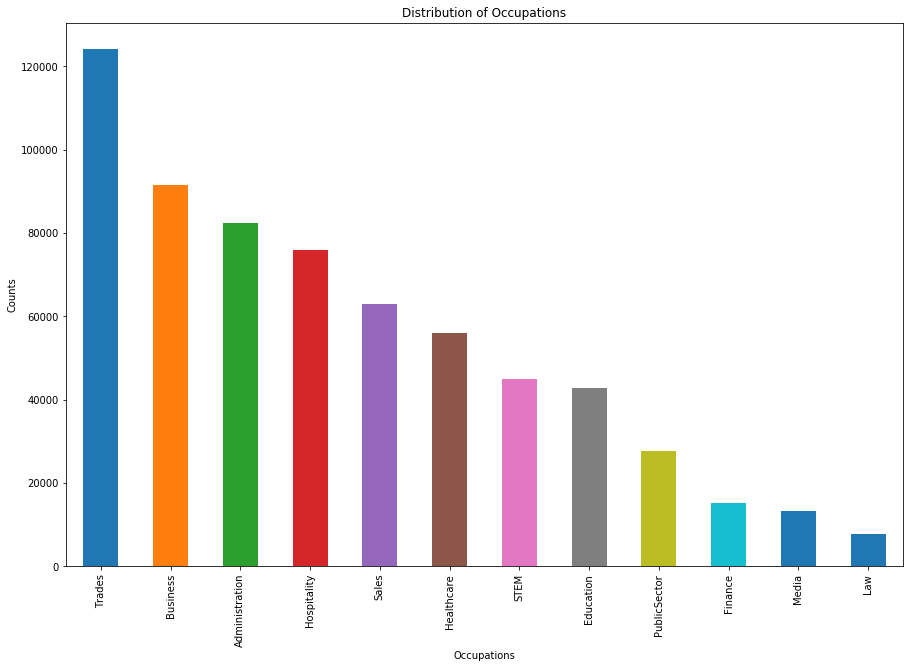

In [23]:
df_pd["OCCRecode"].value_counts().plot(kind="bar",figsize=(15,10))
plt.ylabel("Counts")
plt.xlabel("Occupations")
plt.title("Distribution of Occupations")
plt.show()

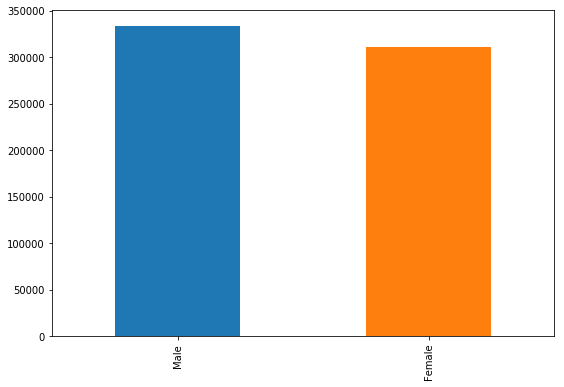

In [24]:
df_pd["SEX"].value_counts().plot(kind="bar",figsize=(9,6))

In [25]:
df_pd["SEX"].value_counts()

Male      333850
Female    311046
Name: SEX, dtype: int64

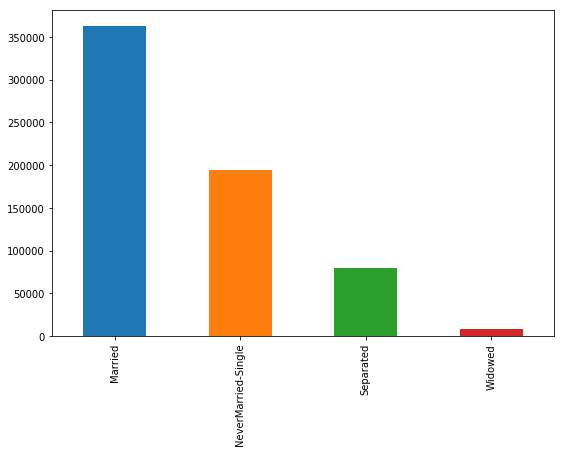

In [26]:
df_pd["MARST"].value_counts().plot(kind="bar",figsize=(9,6))

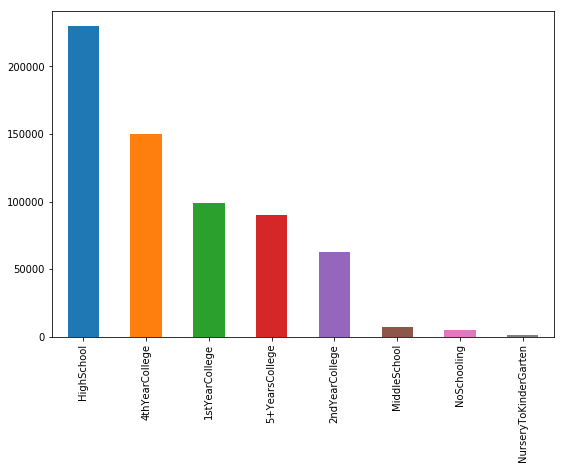

In [27]:
df_pd["EDUC"].value_counts().plot(kind="bar",figsize=(9,6))

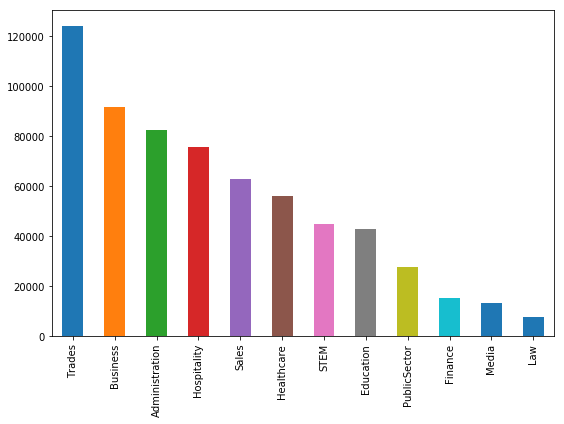

In [28]:
df_pd["OCCRecode"].value_counts().plot(kind="bar",figsize=(9,6))

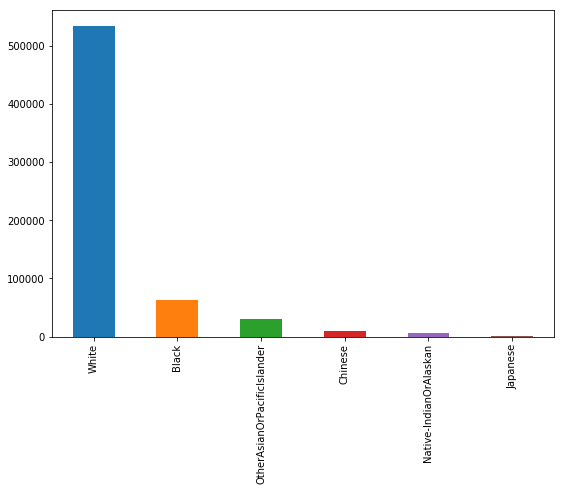

In [29]:
df_pd["RACE"].value_counts().plot(kind="bar",figsize=(9,6))

In [30]:
import seaborn as sb

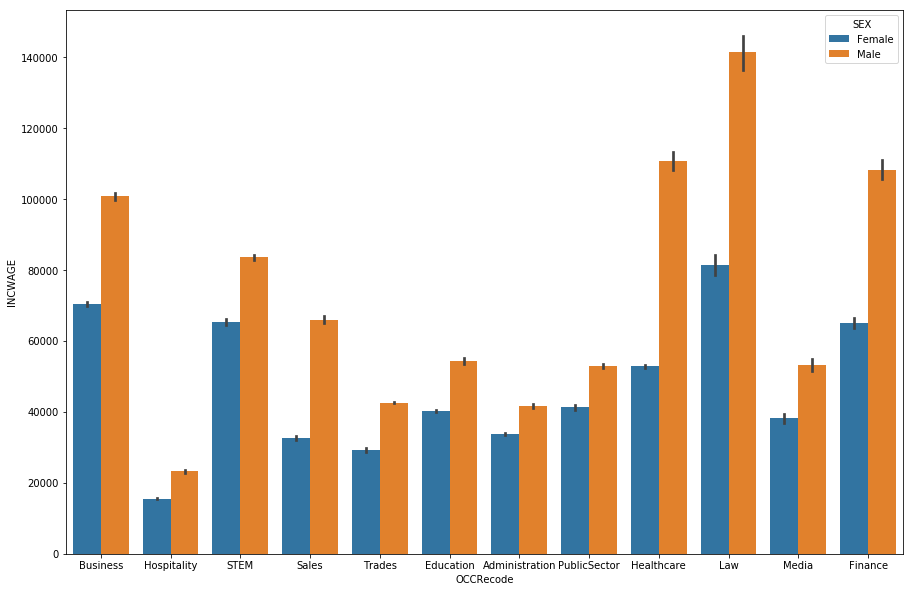

In [31]:
fig, axs = plt.subplots(figsize=(15,10))
sb.barplot(x="OCCRecode",y="INCWAGE",hue="SEX",data=df_pd)

Text(0.5,0.98,'Distribution of Numerical Variables')

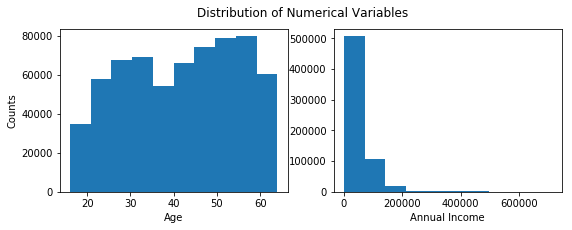

In [32]:
fig, axs = plt.subplots(1,2,figsize=(9,3))
axs[0].hist(df_pd["AGE"])
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Counts")
axs[1].hist(df_pd["INCWAGE"])
axs[1].set_xlabel("Annual Income")
fig.suptitle("Distribution of Numerical Variables")

In [33]:
df_pd["SEX"] = df_pd["SEX"].astype('str')
df_pd["MARST"] = df_pd["MARST"].astype('str')
df_pd["RACE"] = df_pd["RACE"].astype('str')
df_pd["EDUC"] = df_pd["EDUC"].astype('str')
df_pd["OCCRecode"] = df_pd["OCCRecode"].astype('str')

In [34]:
df_pd.describe()

,AGE,INCWAGE,PayGapratio
count,644896.000000,644896.000000,644896.000000
mean,41.735869,52286.674124,1.082081
std,13.200091,64021.404869,1.180895
min,16.000000,0.000000,0.000000
25%,31.000000,18000.000000,0.425000
50%,42.000000,37800.000000,0.849520
75%,53.000000,65000.000000,1.388889
max,64.000000,710000.000000,39.444444


,SEX,AGE,MARST,RACE,EDUC,OCCRecode,INCWAGE,PayGapratio
0,Female,31,NeverMarried-Single,White,4thYearCollege,Business,38500,0.481250
1,Female,37,Separated,Black,HighSchool,Business,18000,0.225000
2,NaN,21,NeverMarried-Single,Black,1stYearCollege,Hospitality,15000,0.833333
3,NaN,20,NeverMarried-Single,Black,1stYearCollege,Hospitality,1200,0.066667


count     311046
unique         1
top       Female
freq      311046
Name: SEX, dtype: object

In [36]:
df_pd.describe(include='object')

,SEX,MARST,RACE,EDUC,OCCRecode
count,644896,644896,644896,644896,644896
unique,2,4,6,8,12
top,Male,Married,White,HighSchool,Trades
freq,333850,363375,533932,229900,124246


In [37]:
df_pd.isnull().any()

SEX            False
AGE            False
MARST          False
RACE           False
EDUC           False
OCCRecode      False
INCWAGE        False
PayGapratio    False
dtype: bool

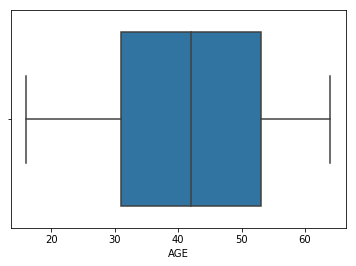

In [38]:
sb.boxplot(df_pd["AGE"])

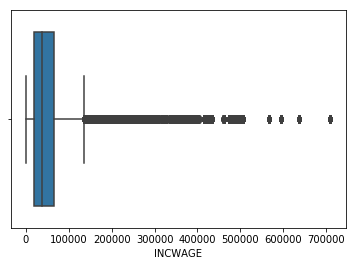

In [39]:
sb.boxplot(df_pd["INCWAGE"])

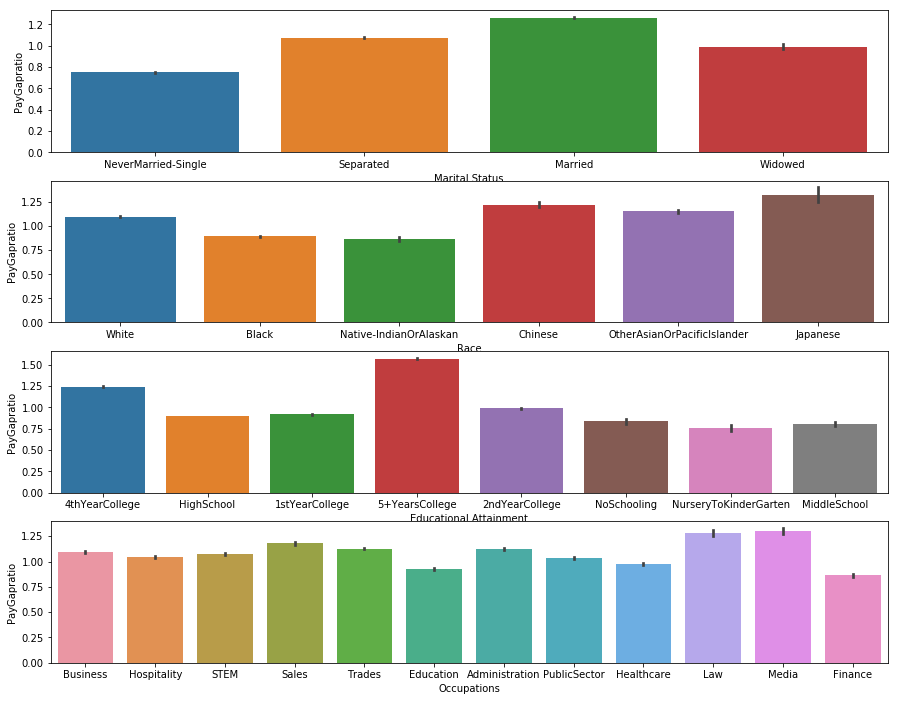

In [47]:
fig, axs = plt.subplots(4,1, figsize=(15,12))
mpg = sb.barplot(x="MARST", y="PayGapratio", data=df_pd, ax=axs[0])
rpg = sb.barplot(x="RACE", y="PayGapratio", data=df_pd, ax=axs[1])
epg = sb.barplot(x="EDUC", y="PayGapratio", data=df_pd, ax=axs[2])
opg = sb.barplot(x="OCCRecode", y="PayGapratio", data=df_pd, ax=axs[3])
mpg.set(xlabel="Marital Status")
rpg.set(xlabel="Race")
epg.set(xlabel="Educational Attainment")
opg.set(xlabel="Occupations")
plt.show()

In [62]:
df_pd["PayGapratio"].describe()

count    311046.000000
mean          0.881261
std           0.922280
min           0.000000
25%           0.357895
50%           0.722222
75%           1.157895
max          35.444444
Name: PayGapratio, dtype: float64

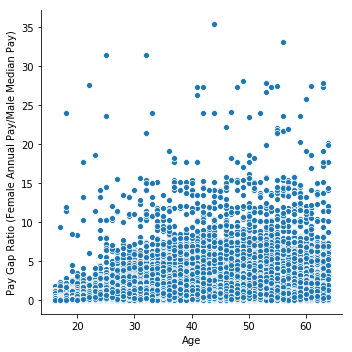

In [60]:
ap = sb.relplot(x="AGE",y="PayGapratio", data=df_pd)
ap.set(xlabel="Age",ylabel="Pay Gap Ratio (Female Annual Pay/Male Median Pay)")